# Imports and Setups

In [1]:
!nvidia-smi

Thu Dec  3 15:13:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    37W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

2.3.0


In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Currently logged in as: wandb (use `wandb login --relogin` to force relogin)


True

# Download and Prepare Dataset

In [19]:
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def preprocess(data):
    img = tf.image.convert_image_dtype(data['image'], tf.float32)
    img = tf.image.resize(img, [256,256])
    return img

trainloader = tfds.load("lfw", split='train', as_supervised=False)

trainloader = (
    trainloader
    .shuffle(1024)
    .map(preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

### Visualize Images

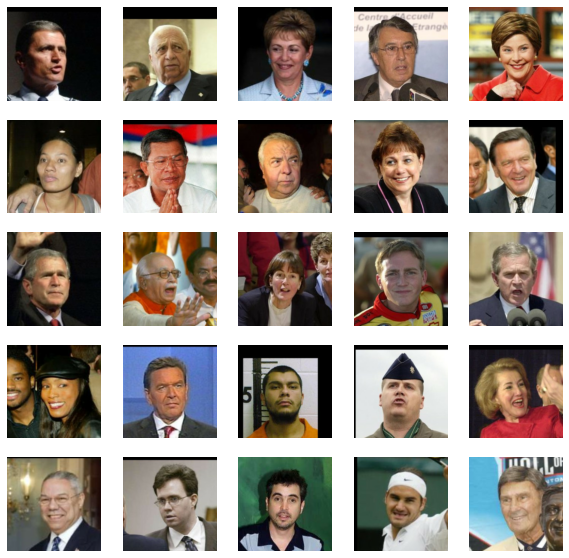

In [20]:
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

img_batch = []
while len(img_batch)<25:
   batch = next(iter(trainloader))
   img_batch.extend(batch)

show_batch(img_batch)

# Model

#### Generator

In [21]:
def build_generator():
    latent_input = Input(shape=(256,))
    x = Dense(16*16*256, use_bias=False)(latent_input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Reshape((16, 16, 256))(x)

    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    gen_image = Conv2D(3, (3,3), strides=(1,1), padding='same', use_bias=False, activation='tanh')(x)

    return Model(latent_input, gen_image)

In [22]:
tf.keras.backend.clear_session()
generator = build_generator()
generator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 65536)             16777216  
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
re_lu (ReLU)                 (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       589824    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)      

#### Discriminator

In [23]:
def build_discriminator():
    image_input = Input(shape=(256,256,3))

    x = Conv2D(256, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(32, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    output = Dense(1)(x)

    return Model(image_input, output)

In [24]:
tf.keras.backend.clear_session()
discriminator = build_discriminator()
discriminator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 256)     19456     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 256)     0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       819328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 128)      

#### WGAN-GP

In [25]:
class WGAN(tf.keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
noise_dim = 256

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

# Set the number of epochs for trainining.
epochs = 20

# Instantiate the WGAN model.
tf.keras.backend.clear_session()

d_model = build_discriminator()
g_model = build_generator()

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.5, beta_2=0.9
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

wandb.init(entity='ayush-thakur', project='gan-zoo')

# initialize callback
gen_image_logger = GeneratedImageLogger(noise_dim)

# Start training the model.
wgan.fit(trainloader, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[WandbCallback(), gen_image_logger])

wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/20
414/414 [==============================] - 517s 1s/step - d_loss: -163.9755 - g_loss: 196.5828
Epoch 2/20
414/414 [==============================] - 517s 1s/step - d_loss: -35.8172 - g_loss: 42.2532
Epoch 3/20
414/414 [==============================] - 517s 1s/step - d_loss: -24.8084 - g_loss: -29.7516
Epoch 4/20
414/414 [==============================] - 517s 1s/step - d_loss: -25.0100 - g_loss: -7.7275
Epoch 5/20
414/414 [==============================] - 518s 1s/step - d_loss: -30.1431 - g_loss: 21.1720
Epoch 6/20
414/414 [==============================] - 518s 1s/step - d_loss: -27.8034 - g_loss: 24.8880
Epoch 7/20
414/414 [==============================] - 518s 1s/step - d_loss: -21.5504 - g_loss: 23.1525
Epoch 8/20
414/414 [==============================] - 517s 1s/step - d_loss: -18.5998 - g_loss: 18.9176
Epoch 9/20
414/414 [==============================] - 517s 1s/step - d_loss: -17.2065 - g_loss: 30.9729
Epoch 10/20
414/414 [==============================] - 517s 1

# Training Loop

#### Loss


In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Optim

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Train step

In [28]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

#### Callback

In [16]:
class GeneratedImageLogger(tf.keras.callbacks.Callback):
    def __init__(self, noise_dim):
      super(GeneratedImageLogger, self).__init__()
      self.noise = tf.random.normal([32, noise_dim])

    def on_epoch_end(self, logs, epoch):
      generated_image = generator(self.noise, training=False)

      wandb.log({"gen_images": [wandb.Image(image)
                            for image in generated_image]})

#### Train Loop

In [30]:
def train(dataset, epochs, gen_image_logger):
  for epoch in range(epochs):
    gen = []
    disc = []
    for step, image_batch in enumerate(dataset):
      gen_loss, disc_loss = train_step(image_batch)
      gen.append(gen_loss)
      disc.append(disc_loss)

      if step%10==0:
          wandb.log({'batch_gen_loss': gen_loss, 'batch_disc_loss': disc_loss})

    print ('Epoch: {}, gen_loss: {}, disc_loss: {}'.format(epoch + 1, np.mean(gen), np.mean(disc)))
    wandb.log({'Epoch': epoch, 'disc_loss': np.mean(disc), 'gen_loss': np.mean(gen)})

    gen_image_logger.on_epoch_end(None, epoch)

# Train with W&B 

In [31]:
EPOCHS = 200
noise_dim = 256

# initialize wandb run
wandb.init(entity='ayush-thakur', project='gan-zoo')

# initialize model
tf.keras.backend.clear_session()
generator = build_generator()
discriminator = build_discriminator()

# initialize callback
gen_image_logger = GeneratedImageLogger()

# train
train(trainloader, EPOCHS, gen_image_logger)

wandb.finish()

wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1, gen_loss: 10.739920616149902, disc_loss: 0.03237710893154144
Epoch: 2, gen_loss: 11.710268020629883, disc_loss: 0.15973733365535736


KeyboardInterrupt: 

In [40]:
wandb.finish()

In [ ]:
generator.save('dcgan_generator.h5')
discriminator.save('dcgan_discriminator.h5')

In [ ]:
run = wandb.init(entity='ayush-thakur', project='gan-zoo', job_type='producer')

artifact = wandb.Artifact('dcgan_model', type='model')

artifact.add_file('dcgan_generator.h5')
artifact.add_file('dcgan_discriminator.h5')

run.log_artifact(artifact)
run.join()